##Accessing Kaggle





In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240521%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240521T090617Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D96f355cc7c6a015e418c5871c7ff05fa1455d25898525ce76a4546fe5410d27a1e0315d2ef7281695b4dd5077276b7a874ba12fc8f6e0e5d87605a34cd117a9a790c2cf2db5c396f0ea83aa89c5de3f6dd3aa451a65d2a528f8edadafd8047f11846c7bc38d6b21e44408c96526065c1ac810925f3c1201304f3692c2bb692fb49c130181022849391d6dc505840e967298792f1efc1294ae6778c299bca6e411139520059763652dfdaec5c1cd465d1623c15784b9ef95dba88c7b1784d8241b633e4152b50226ede38dc1c0baf49feaafd8df7df9fdfdff75c9ae9657355b0511adaca15cc95d2ae32b7a75b293d5ed95c93663c5a0257a3e986be156b82d6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


## Loading Libararies

In [2]:
!pip install tensorflow-privacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.23.0
    Uninstalling tensorflow-probability-0.23.0:
      Successfully uninstalled tensorflow-probability-0.23.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow_privacy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers import dp_optimizer_keras

## Loading Data

In [21]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    l=[]
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            l.append(class_num)
            try:
              img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
              # img_arr = cv2.imread(os.path.join(path, img))
              resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
              data.append(resized_arr)
            except Exception as e:
                print(e)
            # l.append(class_num)
    return np.array(data),l

In [22]:
x_train,y_train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
x_test,y_test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
x_val,y_val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [23]:
XTRAIN,YTRAIN=  x_train,y_train
XTEST,YTEST=    x_test,y_test
XVAL,YVAL=    x_val,y_val

In [24]:
y_train=y_train[1:-1]
print(len(y_train))
y_val=y_val[1:-1]
print(len(y_val))

5216
16


In [25]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


In [26]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(5216, 150, 150, 1)
(16, 150, 150, 1)
(5216,)
(16,)


In [27]:
# removed_elements=np.concatenate((x_train[:50],x_train[-50:]))
# x_train=x_train[50:-50]
# x_val=np.concatenate((x_val,removed_elements))
# removed_elements_val=np.concatenate((y_train[:50],y_train[-50:]))
# y_train=y_train[50:-50]
# y_val=np.concatenate((y_val,removed_elements_val))

In [28]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(5216, 150, 150, 1)
(16, 150, 150, 1)
(5216,)
(16,)


## Data Augmentation


In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
train_generator=datagen.flow(x_train,y_train,batch_size=32)
val_generator=datagen.flow(x_val,y_val,shuffle=False)
print((train_generator.n))
print((val_generator.n))

5216
16


## Model With Keras


In [ ]:
modelWK = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modelWK.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history2 = modelWK.fit(train_generator,epochs = 12 , validation_data = val_generator ,callbacks = [learning_rate_reduction])

Epoch 1/12
160/160 [==============================] - 15s 81ms/step - loss: 0.3276 - accuracy: 0.8602 - val_loss: 2.9946 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/12
160/160 [==============================] - 13s 81ms/step - loss: 0.2310 - accuracy: 0.9036 - val_loss: 4.9506 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3/12
160/160 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.9240
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
160/160 [==============================] - 13s 80ms/step - loss: 0.1893 - accuracy: 0.9240 - val_loss: 1.8473 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 4/12
160/160 [==============================] - 13s 81ms/step - loss: 0.1626 - accuracy: 0.9404 - val_loss: 2.5289 - val_accuracy: 0.5000 - lr: 0.0030
Epoch 5/12
160/160 [==============================] - 13s 81ms/step - loss: 0.1551 - accuracy: 0.9414 - val_loss: 1.6045 - val_accuracy: 0.5690 - lr: 0.0030
Epoch 6/12
160/160 [==============================] - 

In [ ]:
# predictions = model.predict_classes(x_test)
predictions2 = (modelWK.predict(x_test) > 0.5).astype("int32")
predictions2 = predictions2.reshape(1,-1)[0]
# predictions[:15]
# Example: Calculate accuracy
accuracy2 = accuracy_score(y_test, predictions2)
print("Accuracy with Keras: ", accuracy2*100)

20/20 [==============================] - 1s 16ms/step
Accuracy with Keras:  87.82051282051282


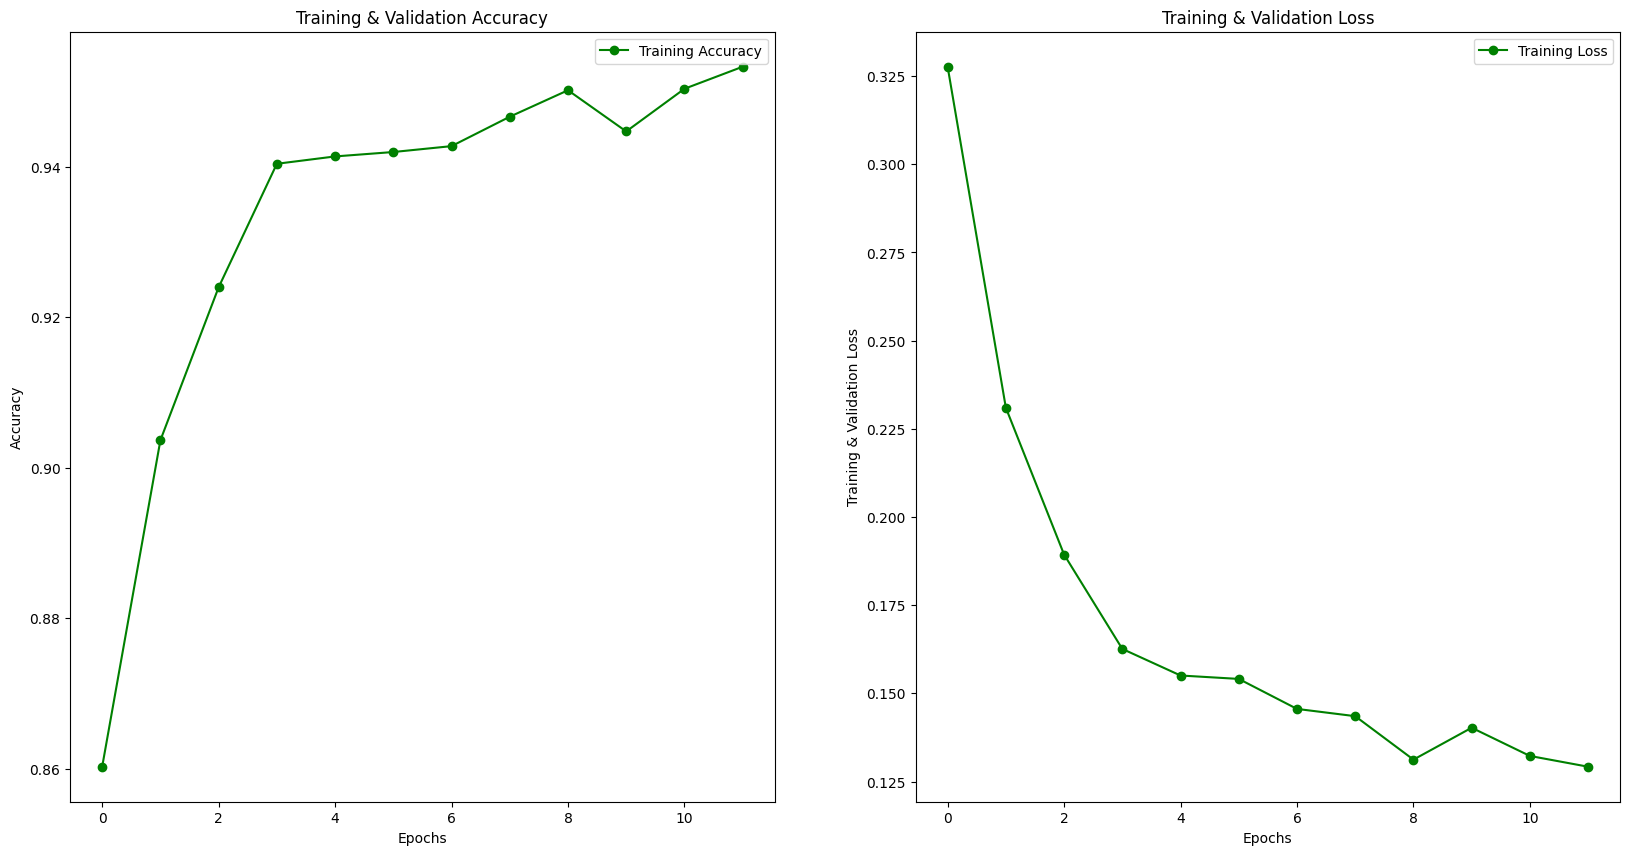

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']
val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training  Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
print(classification_report(y_test, predictions2, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.84      0.99      0.91       390
   Normal (Class 1)       0.98      0.69      0.81       234

           accuracy                           0.88       624
          macro avg       0.91      0.84      0.86       624
       weighted avg       0.89      0.88      0.87       624



<Axes: >

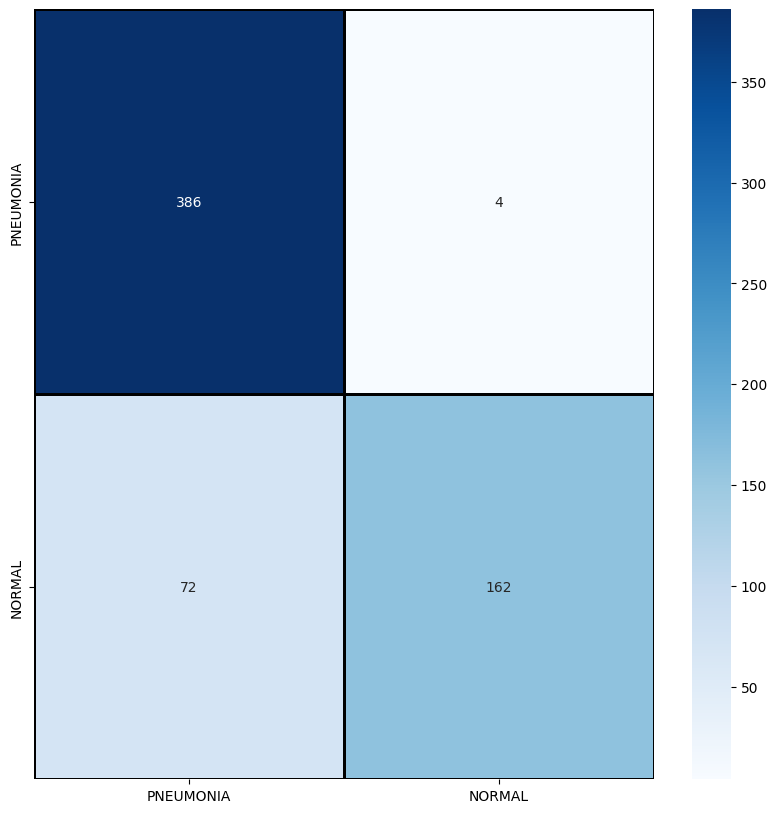

In [ ]:
cm = confusion_matrix(y_test,predictions2)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

## Model with Differential Privacy


In [ ]:
modelWDP = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
l2_norm_clip = 0.3
noise_multiplier = 0.1
num_microbatches = 16
learning_rate = 0.01
epochs=12
batch_size=32
# Select your differentially private optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# Select your loss function
# loss = tf.keras.losses.binary_crossentropy(from_logits=True)
loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,  # Set to True if your model produces logits, False if it produces probabilities
    reduction=tf.losses.Reduction.NONE  # Set the reduction method, e.g., 'sum', 'mean', or 'none'
)

modelWDP.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [ ]:
history3 = modelWDP.fit(train_generator,batch_size=batch_size,epochs = epochs , validation_data = val_generator ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 132s 753ms/step - loss: 0.8095 - accuracy: 0.7623 - val_loss: 2.3916 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/12
163/163 [==============================] - 122s 747ms/step - loss: 0.6694 - accuracy: 0.7866 - val_loss: 2.0659 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.5682 - accuracy: 0.8050
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
163/163 [==============================] - 122s 749ms/step - loss: 0.5682 - accuracy: 0.8050 - val_loss: 2.4014 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 4/12
163/163 [==============================] - 122s 748ms/step - loss: 0.5530 - accuracy: 0.8169 - val_loss: 2.2938 - val_accuracy: 0.5000 - lr: 0.0030
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.5297 - accuracy: 0.8179
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.
163/163 [======================

In [ ]:
predictions3 = (modelWDP.predict(x_test) > 0.5).astype("int32")
predictions3 = predictions3.reshape(1,-1)[0]
# Example: Calculate accuracy
accuracy3 = accuracy_score(y_test, predictions3)
print("Accuracy with Keras Differential Privacy: ", accuracy3*100)




#l2_norm_clip = 1.5
# noise_multiplier = 1.3
# num_microbatches = 8
# learning_rate = 0.01
#accuracy was 0.78

#batch 32
# l2_norm_clip = 1.5
# noise_multiplier = 1.3
# num_microbatches = 16
# learning_rate = 0.01
#accuracy= 0.725

# l2_norm_clip = 1.5
# noise_multiplier = 0.1
# num_microbatches = 16
# learning_rate = 0.01
# epochs=12
# batch_size=32
# accurcy=0.830

#l2_norm_clip = 0.3
#l2_norm_clip = 0.3
# noise_multiplier = 0.1
# num_microbatches = 16
# learning_rate = 0.01
# epochs=12
# batch_size=16
#Accuracy with Keras:  0.842948717948718


20/20 [==============================] - 0s 11ms/step
Accuracy with Keras Differential Privacy:  76.12179487179486


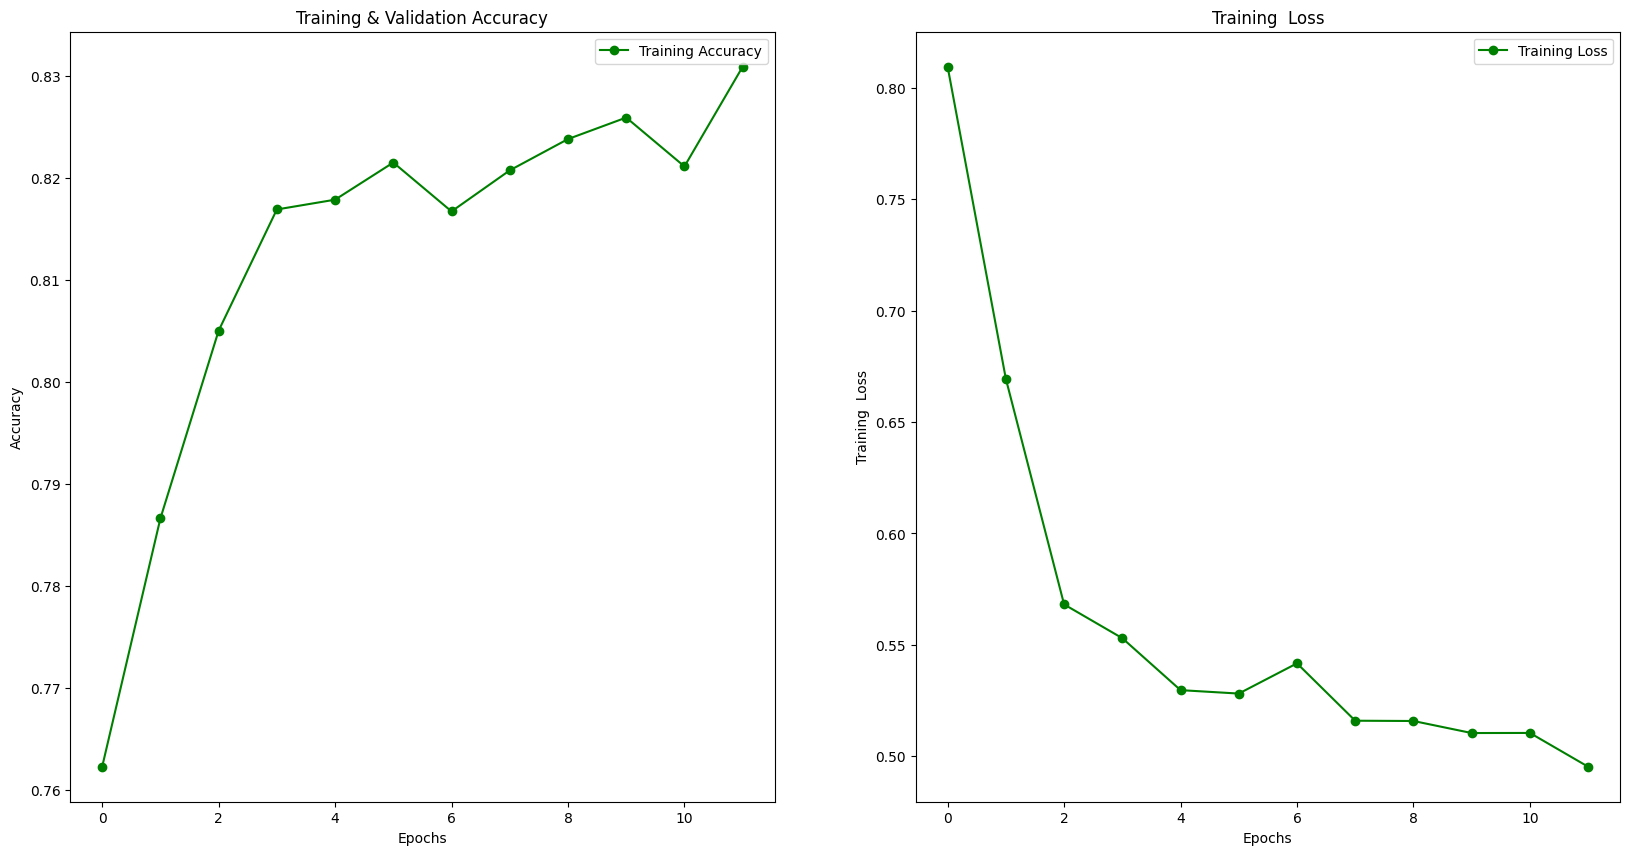

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history3.history['accuracy']
train_loss = history3.history['loss']
val_acc = history3.history['val_accuracy']
val_loss = history3.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training  Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training  Loss")
plt.show()

In [ ]:
print(classification_report(y_test, predictions3, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.74      0.95      0.83       390
   Normal (Class 1)       0.85      0.44      0.58       234

           accuracy                           0.76       624
          macro avg       0.79      0.70      0.71       624
       weighted avg       0.78      0.76      0.74       624



<Axes: >

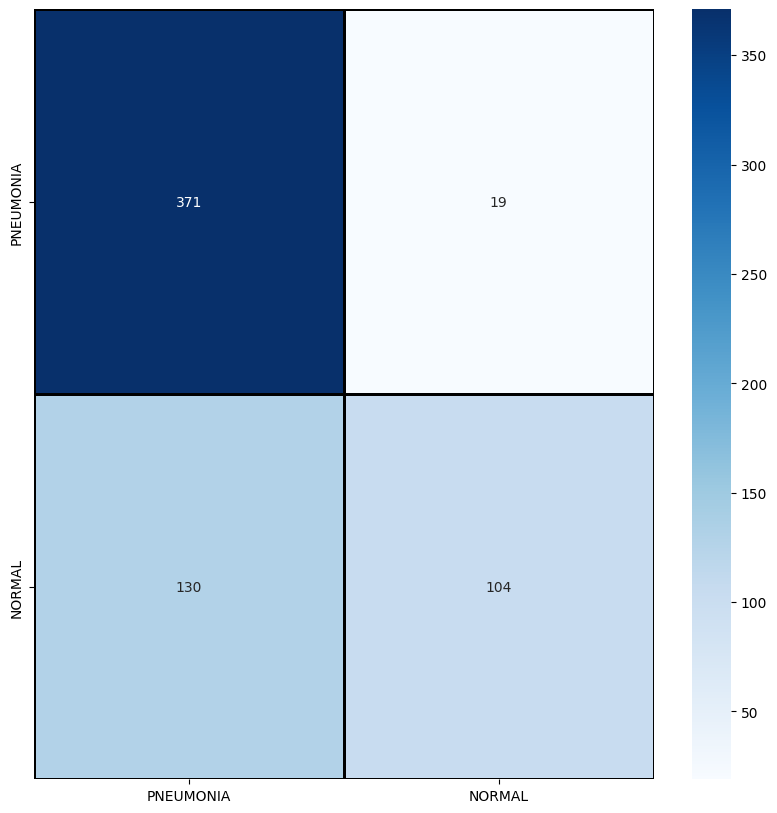

In [ ]:
cm = confusion_matrix(y_test,predictions3)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

##RESNET

##Loading Data for Pretrained models


In [ ]:
TRAIN_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/train'
TEST_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/test'
VAL_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/val'

In [ ]:

from keras.applications import *
import tensorflow as tf
# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard
import keras
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50, preprocess_input

HEIGHT = 150
WIDTH = 150

BATCH_SIZE = 32
class_list = ["class_1", "class_2"]
FC_LAYERS = [1024, 512, 256]
dropout = 0.5
NUM_EPOCHS = 12
STEPS_PER_EPOCH = 163

def build_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        print(fc)
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)
    preditions = Dense(num_classes, activation='softmax')(x)
    finetune_model = Model(inputs = base_model.input, outputs = preditions)
    return finetune_model



In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1,)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rotation_range = 90,
                                  horizontal_flip = True,
                                  vertical_flip = False)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                              # featurewise_center=False,  # set input mean to 0 over the dataset
                              # samplewise_center=False,  # set each sample mean to 0
                              # featurewise_std_normalization=False,  # divide inputs by std of the dataset
                              # samplewise_std_normalization=False,  # divide each input by its std
                              # zca_whitening=False,  # apply ZCA whitening
                              rotation_range = 90,  # randomly rotate images in the range (degrees, 0 to 180)
                              # zoom_range = 0.2, # Randomly zoom image
                              # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                              # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                              horizontal_flip = True,  # randomly flip images
                              vertical_flip=False)
val_generator = val_datagen.flow_from_directory(VAL_DIR,target_size=(HEIGHT,WIDTH),batch_size=BATCH_SIZE)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size = (HEIGHT, WIDTH),
                                                    batch_size = BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size = (HEIGHT, WIDTH),
                                                  batch_size = BATCH_SIZE,shuffle=False)

Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


##Normal RESNET

In [ ]:
base_model_RESNET = ResNet50(weights = 'imagenet',
                       include_top = False,
                       input_shape = (HEIGHT, WIDTH, 3))

resnet50_model = build_model(base_model_RESNET, dropout = dropout,
                                      fc_layers = FC_LAYERS,
                                      num_classes = len(class_list))

# adam = Adam(learning_rate = 0.00001)
optimizer='SGD'
resnet50_model.compile(optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# filepath = "./checkpoints" + "RestNet50" + "_model_weights.keras"
filepath = "./checkpoints/RestNet50_model.weights.h5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor = ["acc"], verbose= 1, mode = "max", save_weights_only=True)
cb=TensorBoard(log_dir=("/home/ubuntu/"))
callbacks_list = [checkpoint, cb]

print(train_generator.class_indices)

# resnet50_model.summary()

1024
512
256
{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
history = resnet50_model.fit(x = train_generator, epochs = NUM_EPOCHS, steps_per_epoch = STEPS_PER_EPOCH,
                                       shuffle = True, validation_data = test_generator)

Epoch 1/12
163/163 [==============================] - 103s 610ms/step - loss: 0.6740 - accuracy: 0.8184 - val_loss: 0.4989 - val_accuracy: 0.7692
Epoch 2/12
163/163 [==============================] - 84s 513ms/step - loss: 0.2803 - accuracy: 0.8944 - val_loss: 0.4952 - val_accuracy: 0.7965
Epoch 3/12
163/163 [==============================] - 86s 527ms/step - loss: 0.2403 - accuracy: 0.9051 - val_loss: 0.4610 - val_accuracy: 0.8333
Epoch 4/12
163/163 [==============================] - 85s 519ms/step - loss: 0.2158 - accuracy: 0.9225 - val_loss: 0.5423 - val_accuracy: 0.8029
Epoch 5/12
163/163 [==============================] - 85s 523ms/step - loss: 0.1984 - accuracy: 0.9227 - val_loss: 0.4307 - val_accuracy: 0.8494
Epoch 6/12
163/163 [==============================] - 85s 518ms/step - loss: 0.1845 - accuracy: 0.9306 - val_loss: 0.5070 - val_accuracy: 0.8205
Epoch 7/12
163/163 [==============================] - 84s 518ms/step - loss: 0.1785 - accuracy: 0.9385 - val_loss: 0.4199 - val_a

In [ ]:
resnet50_model.save("xray_resnet50.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


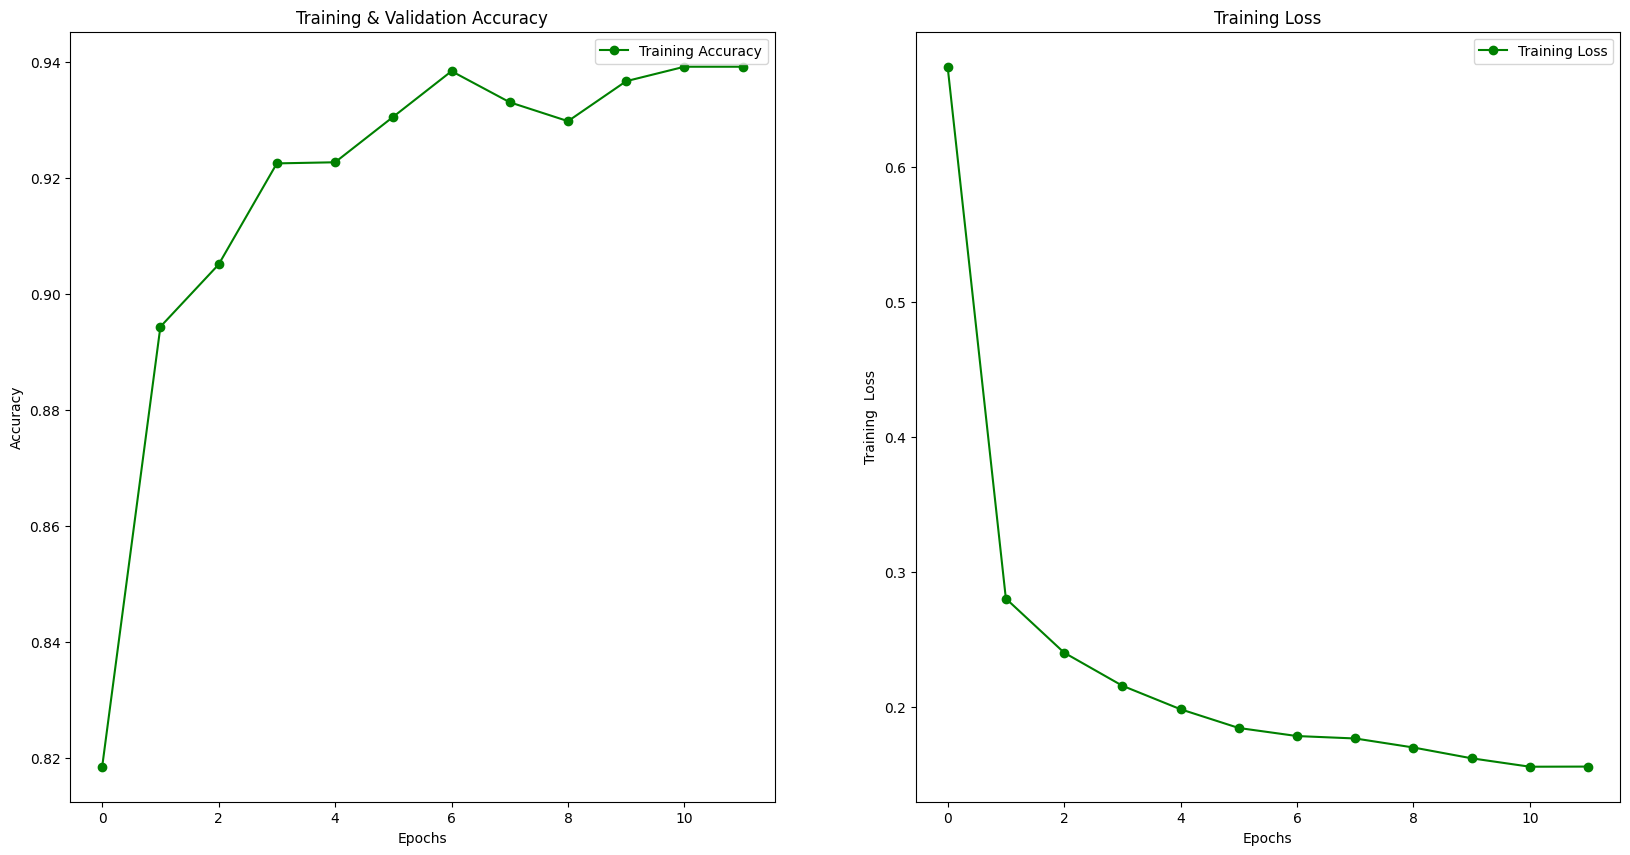

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()

20/20 [==============================] - 9s 394ms/step


<Axes: >

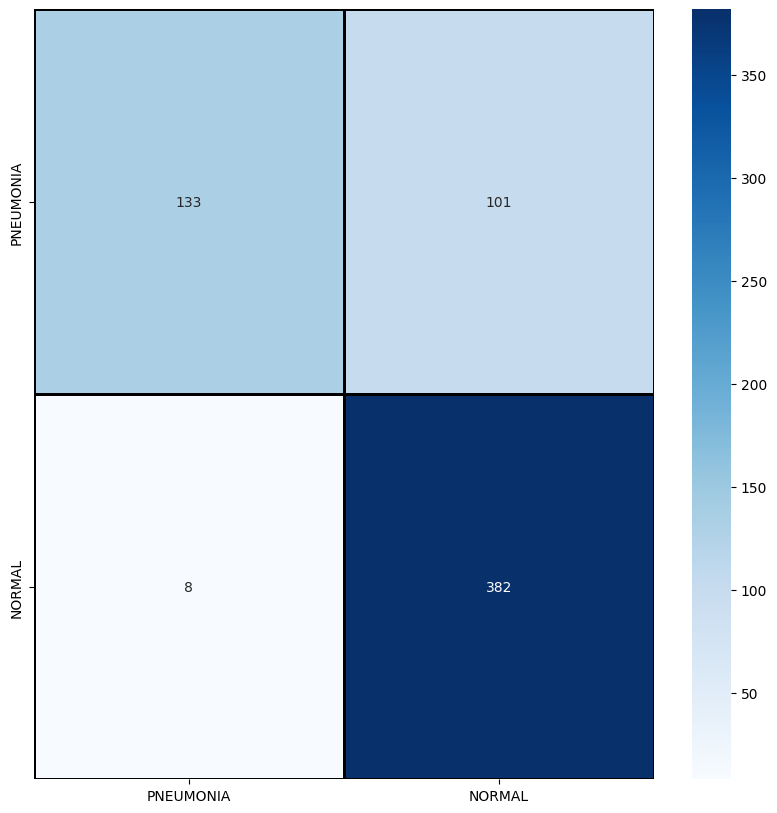

In [ ]:
predictions4 = resnet50_model.predict(test_generator)
predictions4 = np.argmax(predictions4, axis=1)

cm = confusion_matrix(test_generator.classes,predictions4)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
print(classification_report(y_test, predictions4, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.96      0.35      0.51       390
   Normal (Class 1)       0.47      0.97      0.64       234

           accuracy                           0.58       624
          macro avg       0.71      0.66      0.57       624
       weighted avg       0.78      0.58      0.56       624



In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

print(f"Training Accuracy: {training_accuracy[-1]:.4f}")
print(f"Validation Accuracy: {validation_accuracy[-1]:.4f}")
print(f"Training Loss: {training_loss[-1]:.4f}")
print(f"Validation Loss: {validation_loss[-1]:.4f}")

accuracy = (validation_accuracy[-1] * 100)
print(f"\n\nModel Accuracy: {accuracy:.2f}%")

Training Accuracy: 0.9392
Validation Accuracy: 0.8381
Training Loss: 0.1559
Validation Loss: 0.4583


Model Accuracy: 83.81%


In [ ]:
# Y_pred = resnet50_model.predict(test_generator)
# y_pred = np.argmax(Y_pred, axis=1)
# print('Confusion Matrix')
# cf_matrix = confusion_matrix(test_generator.classes, y_pred)
# print(confusion_matrix(test_generator.classes, y_pred))

##*Differentially Private Resnet*

In [4]:
TRAIN_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/train'
TEST_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/test'
VAL_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/val'

In [5]:

from keras.applications import *
import tensorflow as tf
# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard
import keras
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50, preprocess_input

HEIGHT = 150
WIDTH = 150

BATCH_SIZE = 32
class_list = ["class_1", "class_2"]
FC_LAYERS = [1024, 512, 256]
dropout = 0.5
NUM_EPOCHS = 12
STEPS_PER_EPOCH = 163

def build_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        print(fc)
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)
    preditions = Dense(num_classes, activation='softmax')(x)
    finetune_model = Model(inputs = base_model.input, outputs = preditions)
    return finetune_model



In [6]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1,)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rotation_range = 90,
                                  horizontal_flip = True,
                                  vertical_flip = False)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size = (HEIGHT, WIDTH),
                                                    batch_size = BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size = (HEIGHT, WIDTH),
                                                  batch_size = BATCH_SIZE)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
l2_norm_clip = 1.5
noise_multiplier = 0.1
num_microbatches = 8
learning_rate = 0.01
epochs=12
batch_size=32


optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# Select your loss function
# loss = tf.keras.losses.binary_crossentropy(from_logits=True)
loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,  # Set to True if your model produces logits, False if it produces probabilities
    reduction=tf.losses.Reduction.NONE  # Set the reduction method, e.g., 'sum', 'mean', or 'none'
)

# modelWDP.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [8]:
base_model_RESNETDP = ResNet50(weights = 'imagenet',
                       include_top = False,
                       input_shape = (HEIGHT, WIDTH, 3))

resnet50_model_DP = build_model(base_model_RESNETDP, dropout = dropout,
                                      fc_layers = FC_LAYERS,
                                      num_classes = len(class_list))

# adam = Adam(learning_rate = 0.00001)

resnet50_model_DP.compile(optimizer, loss=loss, metrics=["accuracy"])

# filepath = "./checkpoints" + "RestNet50" + "_model_weights.keras"
filepath = "./checkpoints/RestNet50_model.weights.h5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor = ["acc"], verbose= 1, mode = "max", save_weights_only=True)
cb=TensorBoard(log_dir=("/home/ubuntu/"))
callbacks_list = [checkpoint, cb]

print(train_generator.class_indices)

# resnet50_model.summary()

94765736/94765736 [==============================] - 5s 0us/step
1024
512
256
{'NORMAL': 0, 'PNEUMONIA': 1}


In [9]:
# l2_norm_clip = 1.5
# noise_multiplier = 0.1
# num_microbatches = 16
# learning_rate = 0.01
# epochs=12
# batch_size=32
# accurcy=0.830

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [11]:
history = resnet50_model_DP.fit(x = train_generator, batch_size=batch_size,epochs = 12,shuffle = True, validation_data = test_generator,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 123s 614ms/step - loss: 1.5399 - accuracy: 0.5953 - val_loss: 0.9905 - val_accuracy: 0.6250 - lr: 0.0100
Epoch 2/12
163/163 [==============================] - 92s 566ms/step - loss: 1.1813 - accuracy: 0.6965 - val_loss: 0.8907 - val_accuracy: 0.6266 - lr: 0.0100
Epoch 3/12
163/163 [==============================] - 91s 560ms/step - loss: 1.0259 - accuracy: 0.7266 - val_loss: 0.8150 - val_accuracy: 0.6314 - lr: 0.0100
Epoch 4/12
163/163 [==============================] - 90s 551ms/step - loss: 0.9340 - accuracy: 0.7498 - val_loss: 0.7676 - val_accuracy: 0.6378 - lr: 0.0100
Epoch 5/12
163/163 [==============================] - 92s 566ms/step - loss: 0.8629 - accuracy: 0.7627 - val_loss: 0.6712 - val_accuracy: 0.6715 - lr: 0.0100
Epoch 6/12
163/163 [==============================] - 93s 569ms/step - loss: 0.8236 - accuracy: 0.7715 - val_loss: 0.7053 - val_accuracy: 0.6731 - lr: 0.0100
Epoch 7/12
163/163 [==============================]

In [12]:
resnet50_model_DP.save("xray_resnet50.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


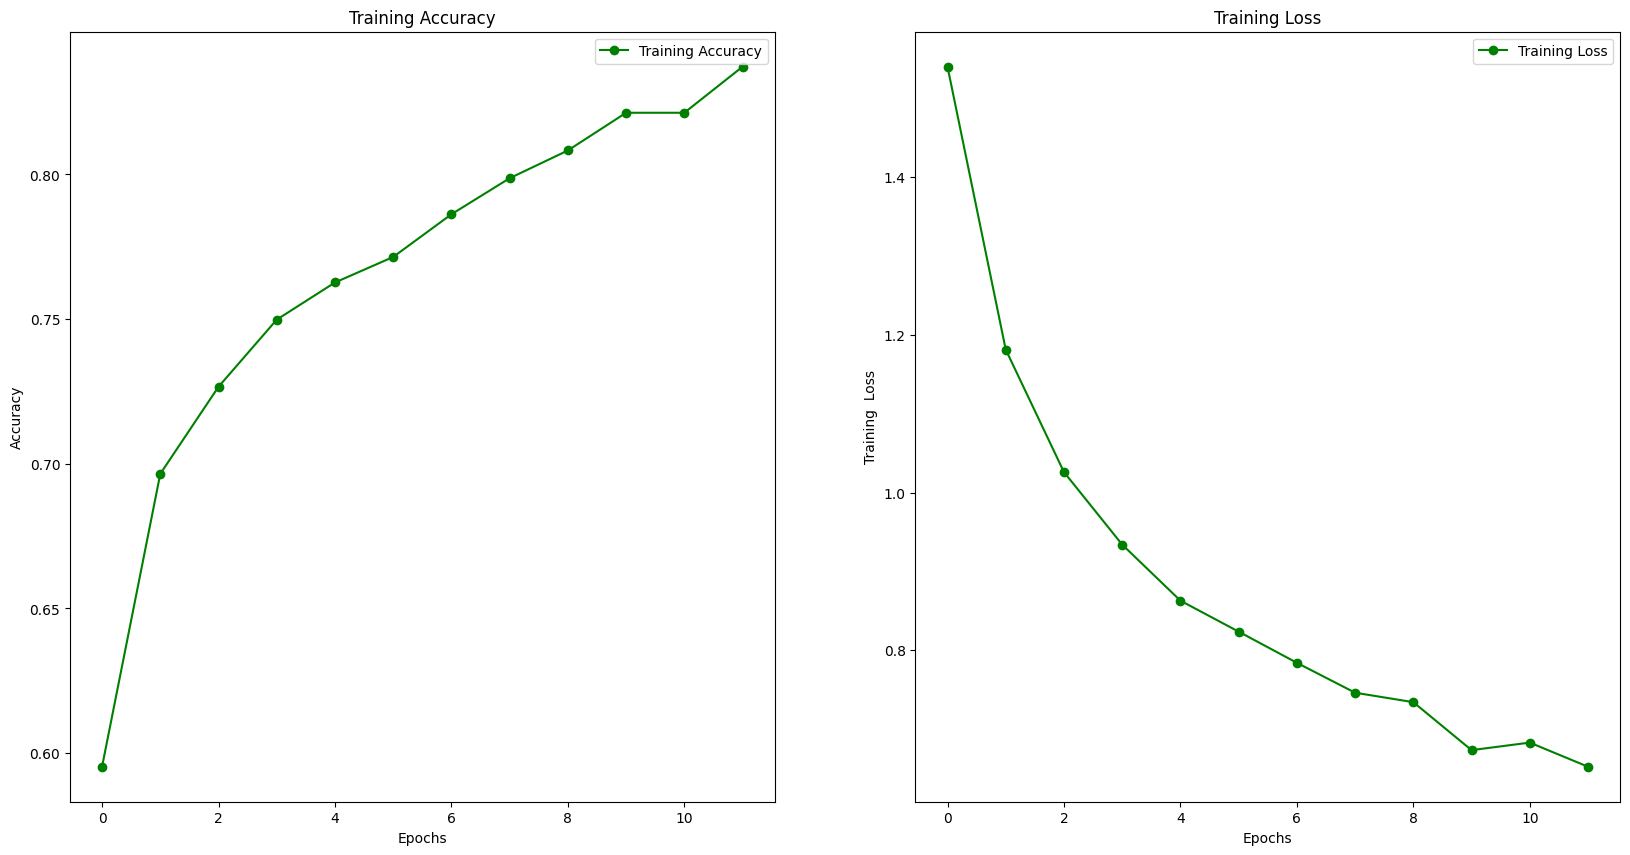

In [13]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training  Loss")
plt.show()

20/20 [==============================] - 14s 605ms/step


<Axes: >

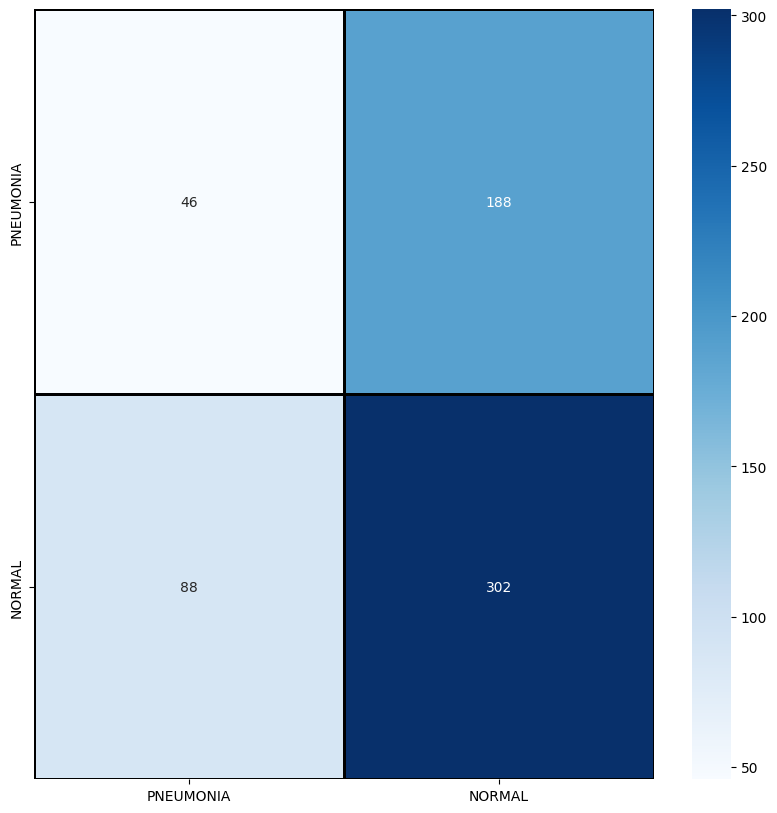

In [19]:
predictions4 = resnet50_model_DP.predict(test_generator)
predictions4 = np.argmax(predictions4, axis=1)

cm = confusion_matrix(test_generator.classes,predictions4)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [29]:
print(classification_report(y_test, predictions4, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.63      0.22      0.32       390
   Normal (Class 1)       0.38      0.79      0.51       234

           accuracy                           0.43       624
          macro avg       0.50      0.50      0.41       624
       weighted avg       0.53      0.43      0.39       624



In [30]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

print(f"Training Accuracy: {training_accuracy[-1]:.4f}")
print(f"Validation Accuracy: {validation_accuracy[-1]:.4f}")
print(f"Training Loss: {training_loss[-1]:.4f}")
print(f"Validation Loss: {validation_loss[-1]:.4f}")

accuracy = (validation_accuracy[-1] * 100)
print(f"\n\nModel Accuracy: {accuracy:.2f}%")

Training Accuracy: 0.8372
Validation Accuracy: 0.7901
Training Loss: 0.6524
Validation Loss: 0.6644


Model Accuracy: 79.01%


In [31]:
# Model Results


# l2_norm_clip = 1.5
# noise_multiplier = 0.1
# num_microbatches = 8
# learning_rate = 0.01
# epochs=12
# batch_size=32
# Training Accuracy: 0.8581
# Validation Accuracy: 0.7804
# Training Loss: 0.6555
# Validation Loss: 0.7987
# Model Accuracy: 78.04%


# l2_norm_clip = 1.5
# noise_multiplier = 0.1
# num_microbatches = 16
# learning_rate = 0.01
# epochs=12
# batch_size=32
# Training Accuracy: 0.7496
# Validation Accuracy: 0.6250
# Training Loss: 1.0770
# Validation Loss: 1.4730
# Model Accuracy: 62.50%


# l2_norm_clip = 1.5
# noise_multiplier = 0.1
# num_microbatches = 8
# learning_rate = 0.01
# epochs=12
# batch_size=32
# Training Accuracy: 0.8321
# Validation Accuracy: 0.7708
# Training Loss: 0.6826
# Validation Loss: 0.6278
# Model Accuracy: 77.08%

## Normal VGG


In [ ]:
TRAIN_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/train'
TEST_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/test'
VAL_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/val'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=12
)


Epoch 1/12
130/130 [==============================] - 69s 519ms/step - loss: 0.6268 - accuracy: 0.9278 - val_loss: 0.0706 - val_accuracy: 0.9727
Epoch 2/12
130/130 [==============================] - 65s 501ms/step - loss: 0.0532 - accuracy: 0.9800 - val_loss: 0.0570 - val_accuracy: 0.9805
Epoch 3/12
130/130 [==============================] - 62s 475ms/step - loss: 0.0216 - accuracy: 0.9928 - val_loss: 0.0505 - val_accuracy: 0.9795
Epoch 4/12
130/130 [==============================] - 64s 494ms/step - loss: 0.0186 - accuracy: 0.9928 - val_loss: 0.0490 - val_accuracy: 0.9814
Epoch 5/12
130/130 [==============================] - 53s 407ms/step - loss: 0.0420 - accuracy: 0.9841 - val_loss: 0.0534 - val_accuracy: 0.9775
Epoch 6/12
130/130 [==============================] - 64s 491ms/step - loss: 0.0048 - accuracy: 0.9978 - val_loss: 0.0517 - val_accuracy: 0.9805
Epoch 7/12
130/130 [==============================] - 52s 396ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0493 - val_ac

In [ ]:
# Create a new data generator for the test images
test_datagen = ImageDataGenerator(rescale=1./255)  # You can apply additional preprocessing if needed

# Load the test images from the directory
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep the order of the images to match predictions with true labels
)

test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Found 624 images belonging to 2 classes.
20/20 [==============================] - 6s 249ms/step - loss: 1.6882 - accuracy: 0.7788
Test Loss: 1.6882089376449585
Test Accuracy: 0.7788461446762085


20/20 [==============================] - 6s 272ms/step


<Axes: >

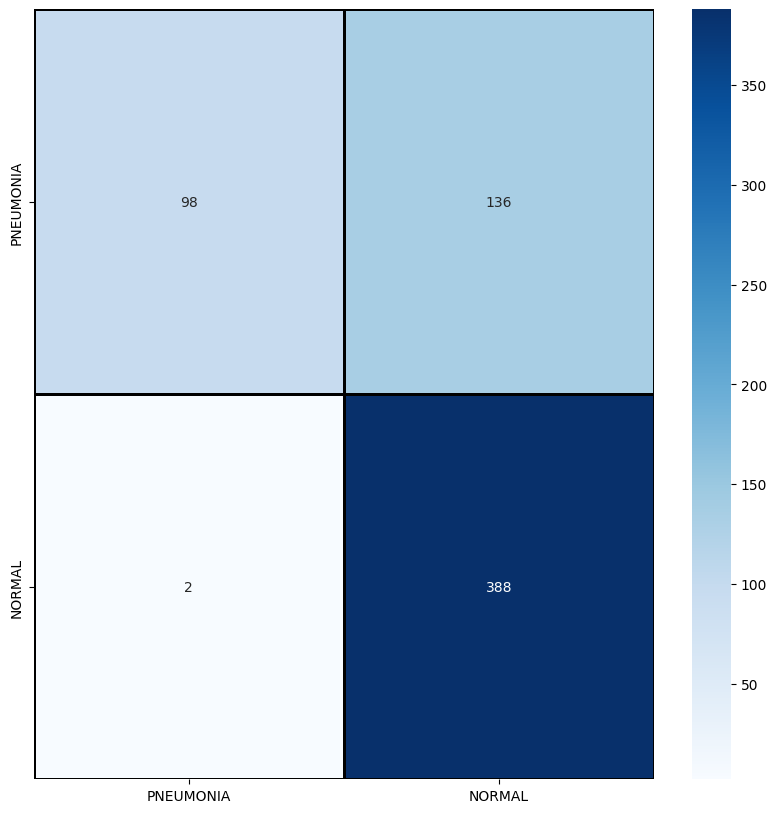

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming `test_generator` is your test data generator
# and `model` is your trained model

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Get true labels from the generator
true_labels = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# print("Confusion Matrix:")
# print(conf_matrix)


In [ ]:
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

      NORMAL       0.98      0.42      0.59       234
   PNEUMONIA       0.74      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.71      0.72       624
weighted avg       0.83      0.78      0.75       624



In [ ]:
model.save('/content/sample_data/xray_VGG.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


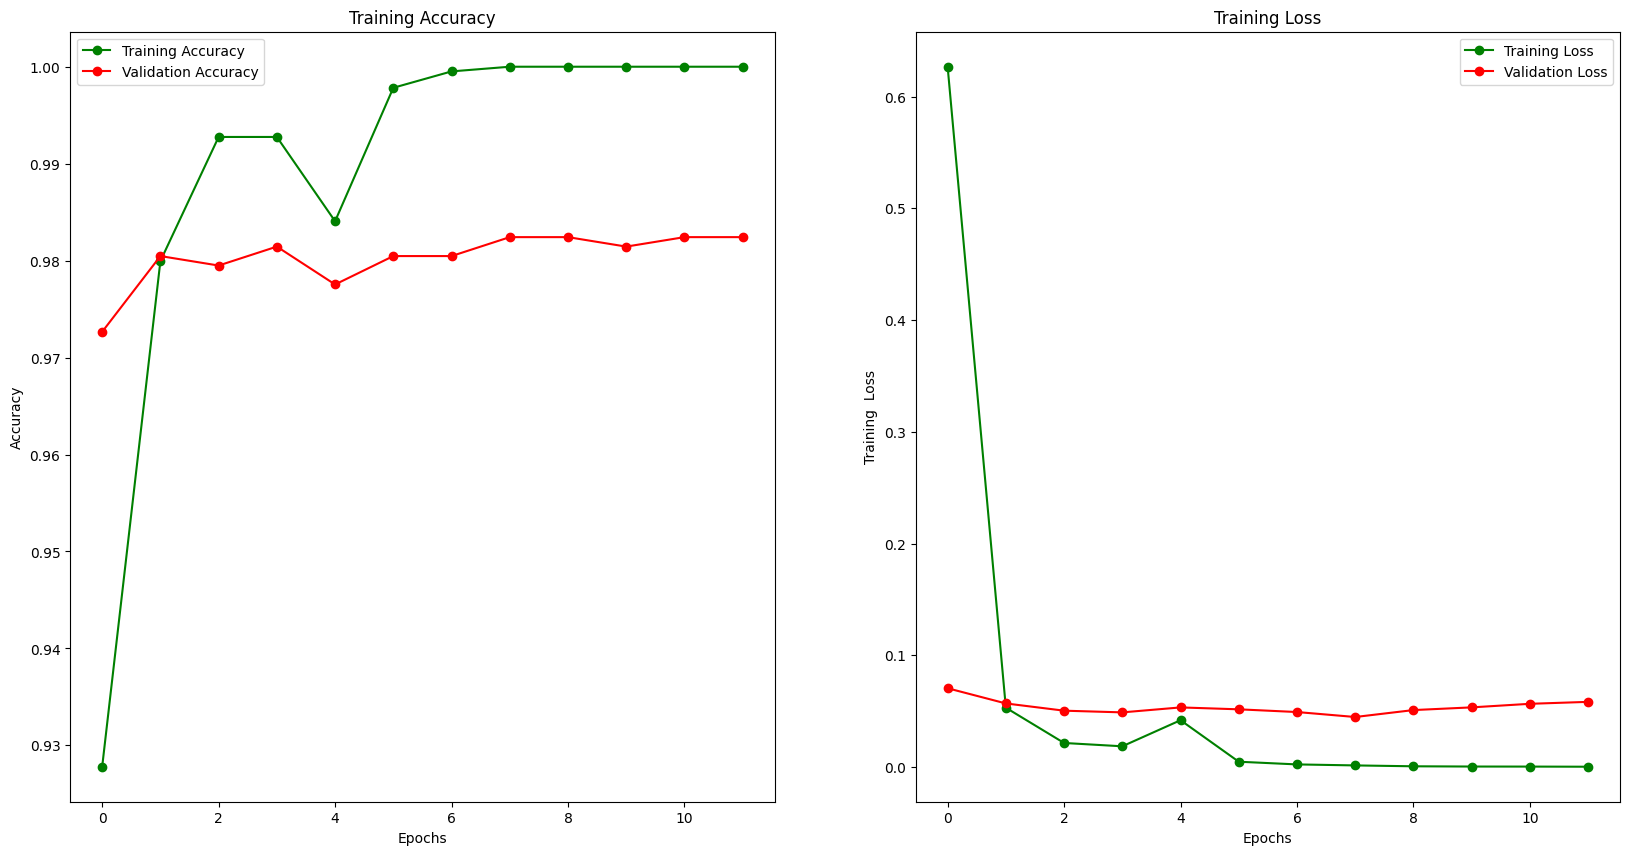

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training  Loss")
plt.show()

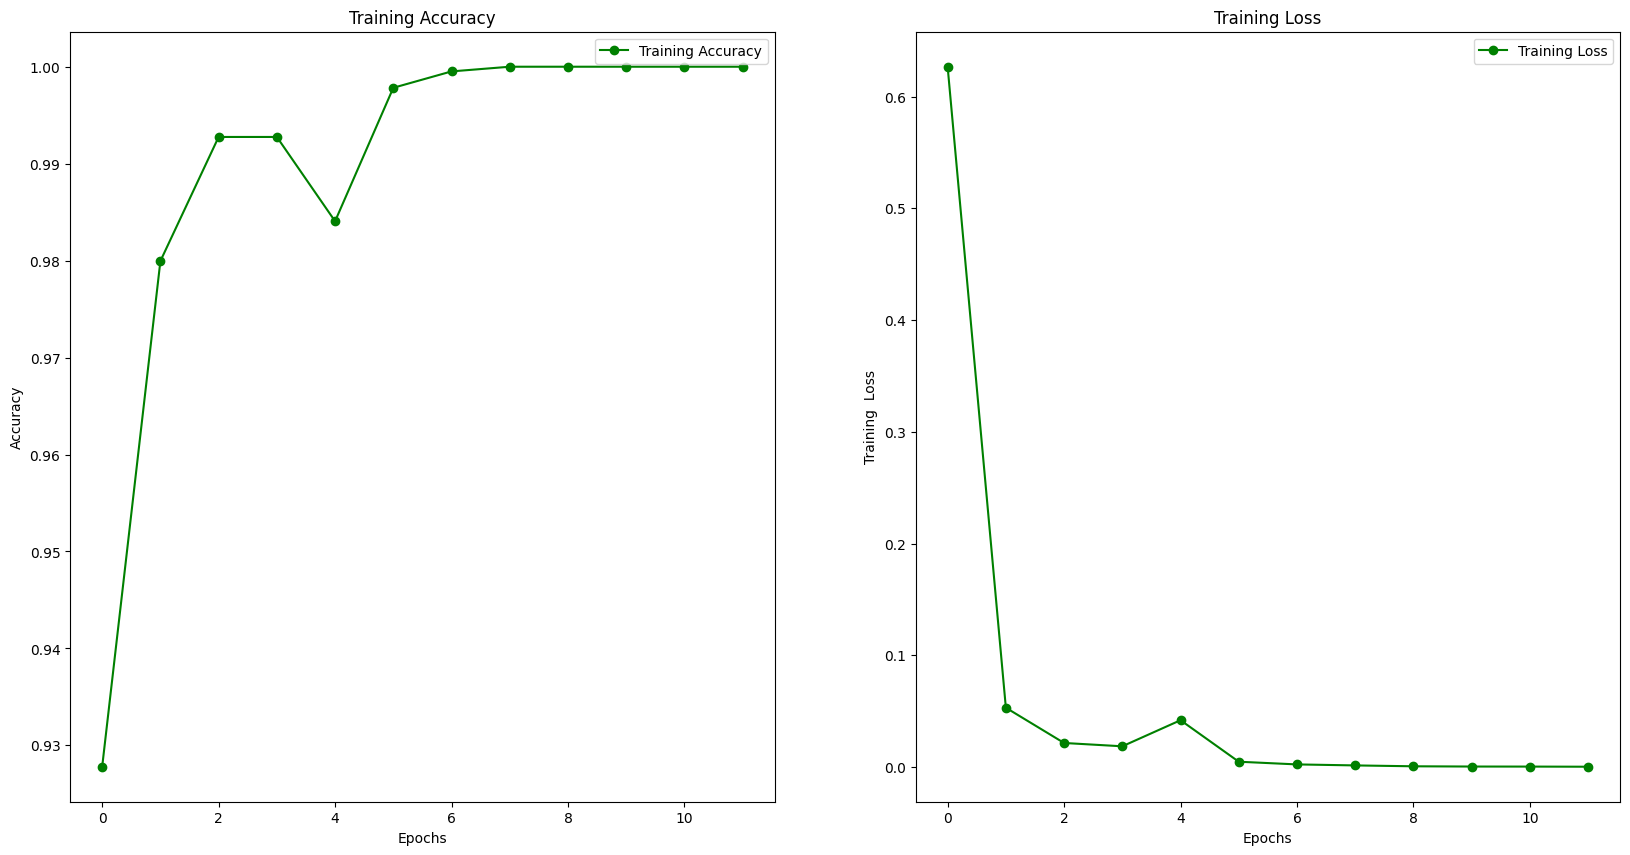

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training  Loss")
plt.show()

##VGG with DP

In [ ]:
TRAIN_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/train'
TEST_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/test'
VAL_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/val'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
l2_norm_clip = 1.5
noise_multiplier = 0.1
num_microbatches = 32
learning_rate = 0.01
epochs=12
batch_size=32


optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    learning_rate=learning_rate)

# Select your loss function
# loss = tf.keras.losses.binary_crossentropy(from_logits=True)
loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,  # Set to True if your model produces logits, False if it produces probabilities
    reduction=tf.losses.Reduction.NONE  # Set the reduction method, e.g., 'sum', 'mean', or 'none'
)


In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history=model.fit(
    train_generator,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=12
)


Epoch 1/12
131/131 [==============================] - 62s 455ms/step - loss: 0.3684 - accuracy: 0.8009 - val_loss: 0.2807 - val_accuracy: 0.8418
Epoch 2/12
131/131 [==============================] - 70s 534ms/step - loss: 0.2894 - accuracy: 0.8509 - val_loss: 0.2637 - val_accuracy: 0.8564
Epoch 3/12
131/131 [==============================] - 69s 529ms/step - loss: 0.2385 - accuracy: 0.8838 - val_loss: 0.1758 - val_accuracy: 0.9189
Epoch 4/12
131/131 [==============================] - 58s 443ms/step - loss: 0.1932 - accuracy: 0.9152 - val_loss: 0.1928 - val_accuracy: 0.8994
Epoch 5/12
131/131 [==============================] - 69s 525ms/step - loss: 0.1709 - accuracy: 0.9279 - val_loss: 0.1552 - val_accuracy: 0.9277
Epoch 6/12
131/131 [==============================] - 69s 526ms/step - loss: 0.1555 - accuracy: 0.9387 - val_loss: 0.1430 - val_accuracy: 0.9365
Epoch 7/12
131/131 [==============================] - 59s 449ms/step - loss: 0.1448 - accuracy: 0.9420 - val_loss: 0.1344 - val_ac

In [ ]:
# Create a new data generator for the test images
test_datagen = ImageDataGenerator(rescale=1./255)  # You can apply additional preprocessing if needed

# Load the test images from the directory
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep the order of the images to match predictions with true labels
)

test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Found 624 images belonging to 2 classes.
20/20 [==============================] - 6s 265ms/step - loss: 0.6884 - accuracy: 0.7660
Test Loss: 0.6883643269538879
Test Accuracy: 0.7660256624221802


20/20 [==============================] - 7s 328ms/step


<Axes: >

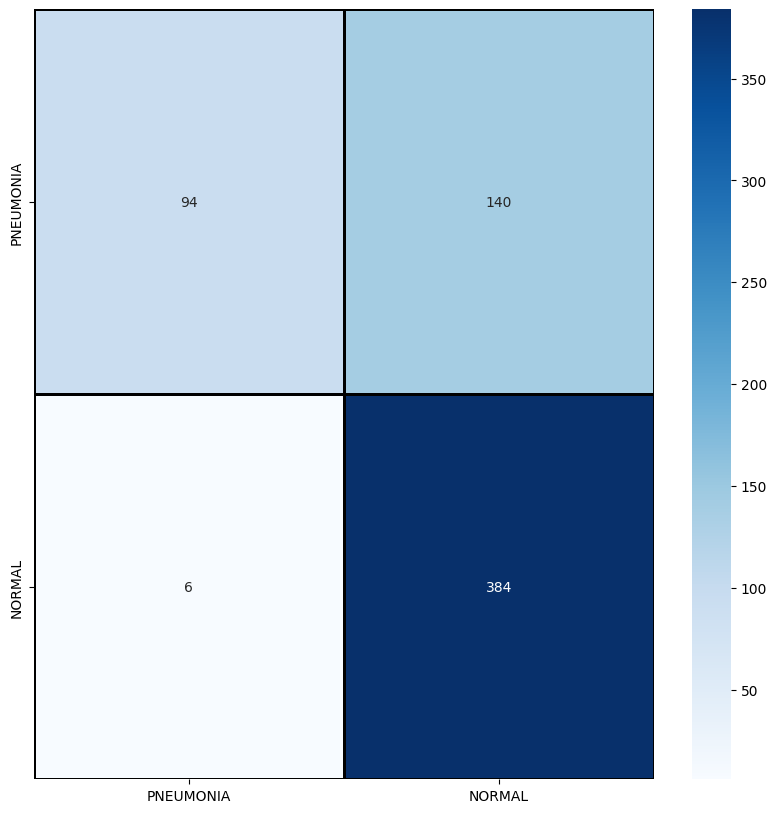

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming `test_generator` is your test data generator
# and `model` is your trained model

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Get true labels from the generator
true_labels = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# print("Confusion Matrix:")
# print(conf_matrix)


In [ ]:
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

      NORMAL       0.94      0.40      0.56       234
   PNEUMONIA       0.73      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.69      0.70       624
weighted avg       0.81      0.77      0.74       624



In [ ]:
model.save('/content/sample_data/xray_vgg_dp.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


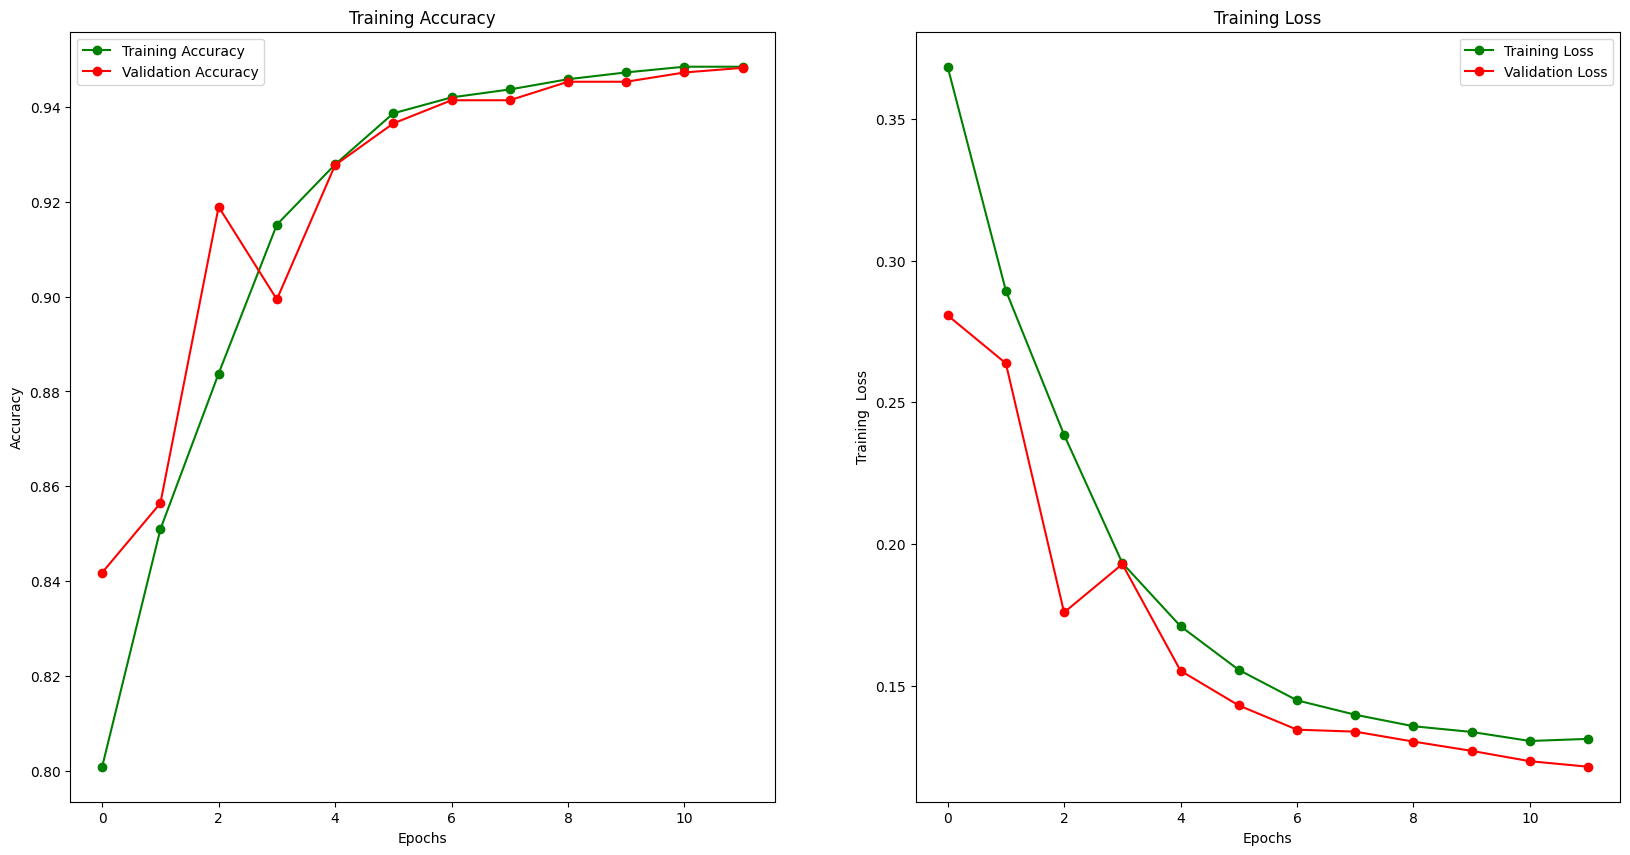

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training  Loss")
plt.show()

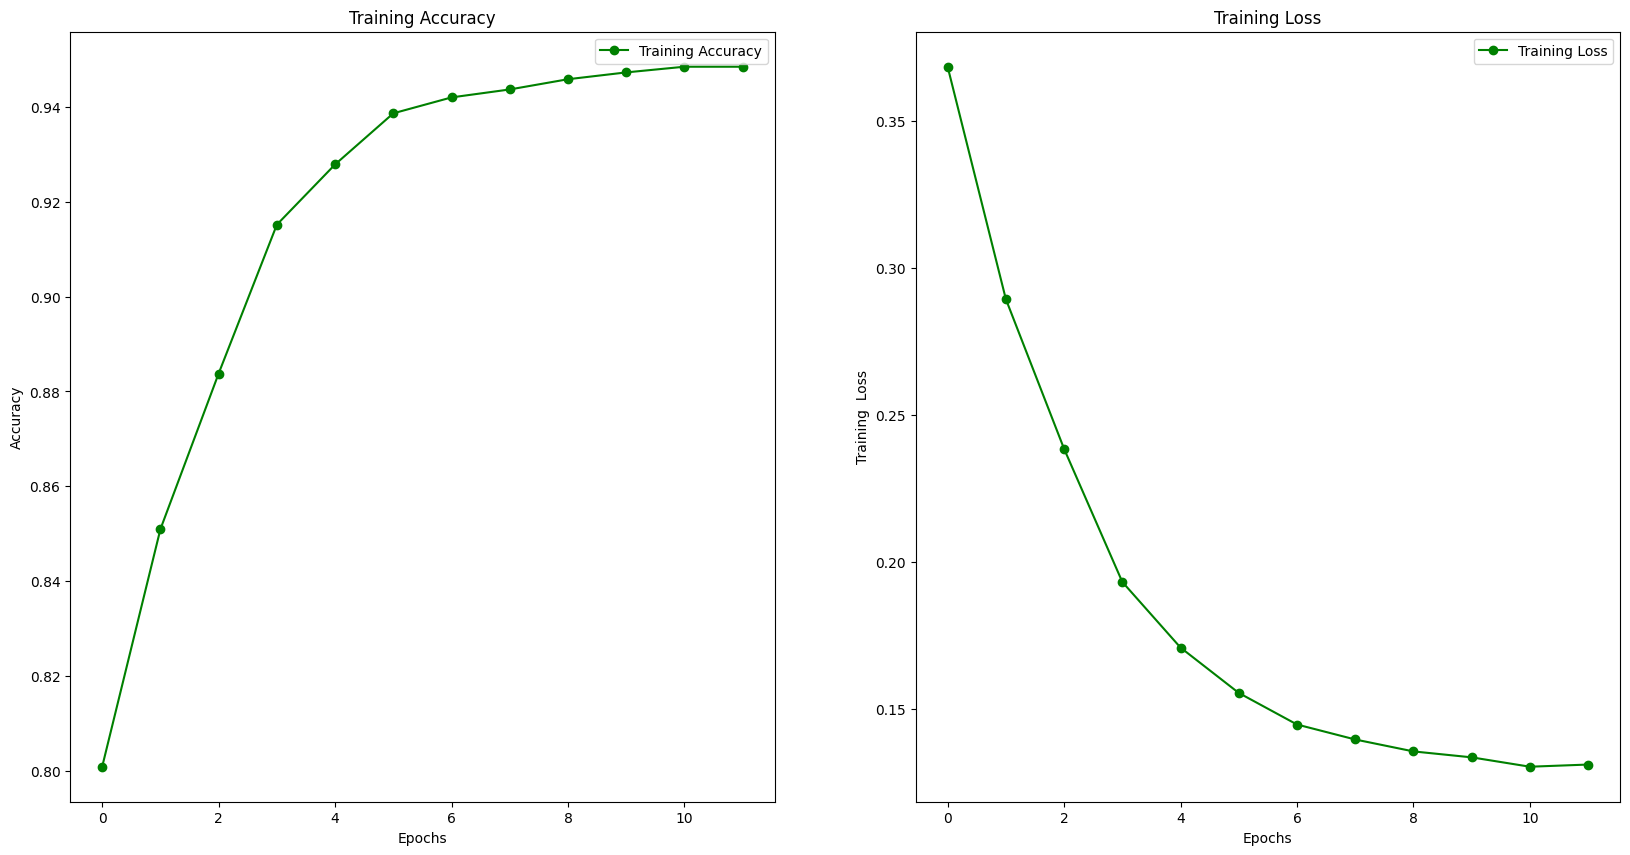

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training  Loss")
plt.show()

##Testing on my CNN for validation graph

In [ ]:
TRAIN_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/train'
TEST_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/test'
VAL_DIR='/input/chest-xray-pneumonia/chest_xray/chest_xray/val'

In [ ]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,
        validaiton_split=0.2)  # randomly flip images



train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
test_datagen = ImageDataGenerator(rescale=1./255)  # You can apply additional preprocessing if needed

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep the order of the images to match predictions with true labels
)

In [ ]:
modelWK = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modelWK.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history2 = modelWK.fit(train_generator,epochs = 12 , validation_data = validation_generator ,callbacks = [learning_rate_reduction])

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training  Loss")
plt.show()

In [ ]:

test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming `test_generator` is your test data generator
# and `model` is your trained model

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Get true labels from the generator
true_labels = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
# print("Confusion Matrix:")
# print(conf_matrix)
